## FROM: End-to-End Pytorch Training & Submission
(Kaggle Notebook) https://www.kaggle.com/code/mayukh18/end-to-end-pytorch-training-submission/notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Jupiter  MacOS
# BASE_DIR = "/Users/johnhanratty/Library/CloudStorage/OneDrive-Personal/IRMA_GIT/Kaggle_SignLanguage/asl-signs"
# WORKING_DIR = BASE_DIR
# !pip install nb_black --quiet
# %load_ext lab_black

# Colab
BASE_DIR = "/content/asl-signs"   #"/content/drive/MyDrive/GaggleSignLang/asl-signs"
WORKING_DIR = "/content/asl-work"
# !pip install nb_black --quiet
# print('-----ok')
# %load_ext nb_black

# KAGGLE
# BASE_DIR = "/kaggle/input/asl-signs"
# WORKING_DIR = "/kaggle/working/"
# !pip install nb_black --quiet --root-user-action=ignore
# %load_ext lab_black

import os
import gc
import shutil
import time

import json
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import normalize

import warnings
warnings.filterwarnings(action='ignore')

LANDMARK_FILES_DIR = f'{BASE_DIR}/train_landmark_files'
TRAIN_FILE = f"{BASE_DIR}/train.csv"

FRAMES_OUT = 8  #12 #16 # 16
PTS_IN_FRAME = 115
DIMS = 3

print('done')


done


In [ ]:
# GET FEATURE FILES FROM GDRIVE 
# COLAB ONLY - MOVE FEATURE FILES TO WORKING DIRECTORY
# 
import os
import gc
import shutil

if os.getenv("COLAB_RELEASE_TAG") and not os.path.exists(WORKING_DIR):
  !mkdir '/content/asl-work'

if os.getenv("COLAB_RELEASE_TAG"):
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_data{FRAMES_OUT}.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/feature_labels.npy", f"{WORKING_DIR}")
    shutil.copy(f"/content/drive/MyDrive/GaggleSignLang/sign_to_prediction_index_map.json", f"{WORKING_DIR}")



# Preprocessing

In [ ]:
# PREPOCESS-A NORMALIZ
datax = np.load(f"{WORKING_DIR}/feature_data{FRAMES_OUT}.npy")
datay = np.load(f"{WORKING_DIR}/feature_labels.npy") 

lips_idx = [61, 185, 40, 39, 37, 0, 267, 269, 270, 409, 291, 78, 191, 80, 81, 82, 13, 312, 311, 310, 415, 308, 95, 88, 178, 87, 14, 317, 402, 318, 324, 146, 91, 181, 84, 17, 314, 405, 321, 375]
data_rows = datax.shape[0]

# MAKE COPY OF DATAX1 input from file
datax = datax.reshape((data_rows, FRAMES_OUT, -1, 3))  ## copy datax

# DEFINE VIEW MATRICES 
start_lips =  0
start_left =  len(lips_idx)
start_pose =  start_left + 21
start_right = start_pose + 33
end_right =   start_right + 21

lips_3d =   datax[:, :, start_lips:start_left, :]
lefth_3d =  datax[:, :, start_left:start_pose, :]
pose_3d =   datax[:, :, start_pose:start_right,:]
righth_3d = datax[:, :, start_right:end_right, :]

print(lips_3d.shape, lefth_3d.shape, pose_3d.shape, righth_3d.shape)

def check_minmax(lips_3d, lefth_3d, pose_3d, righth_3d):
    print("lips", lips_3d.shape, "left", lefth_3d.shape, "pose", pose_3d.shape, "right", righth_3d.shape)
    print("+++++++++++++++++++++++++")
    print("lips max",  np.nanmax(lips_3d[:,:,:,0]),  np.nanmax(lips_3d[:,:,:,1]),   np.nanmax(lips_3d[:,:,:,2]))
    print("lips min",  np.nanmin(lips_3d[:,:,:,0]),  np.nanmin(lips_3d[:,:,:,1]),   np.nanmin(lips_3d[:,:,:,2]))
    print("lefth max", np.nanmax(lefth_3d[:,:,:,0]), np.nanmax(lefth_3d[:,:,:,1]),  np.nanmax(lefth_3d[:,:,:,2]))
    print("lefth min", np.nanmin(lefth_3d[:,:,:,0]), np.nanmin(lefth_3d[:,:,:,1]),  np.nanmin(lefth_3d[:,:,:,2]))
    print("pose max",  np.nanmax(pose_3d[:,:,:,0]),  np.nanmax(pose_3d[:,:,:,1]),   np.nanmax(pose_3d[:,:,:,2]))
    print("pose min",  np.nanmin(pose_3d[:,:,:,0]),  np.nanmin(pose_3d[:,:,:,1]),   np.nanmin(pose_3d[:,:,:,2]))
    print("right max", np.nanmax(righth_3d[:,:,:,0]), np.nanmax(righth_3d[:,:,:,1]),np.nanmax(righth_3d[:,:,:,2]))
    print("right min", np.nanmin(righth_3d[:,:,:,0]), np.nanmin(righth_3d[:,:,:,1]),np.nanmin(righth_3d[:,:,:,2]))

print('BEFORE')
check_minmax(lips_3d, lefth_3d, pose_3d, righth_3d)


# lips_3d =   (lips_3d  - np.nanmin(lips_3d))  /  (np.nanmax(lips_3d)  -  np.nanmin(lips_3d))
# lefth_3d =  (lefth_3d - np.nanmin(lefth_3d)) /  (np.nanmax(lefth_3d) -  np.nanmin(lefth_3d))
# pose_3d =   (pose_3d -  np.nanmin(pose_3d))  /  (np.nanmax(pose_3d)  -  np.nanmin(pose_3d))
# righth_3d = (righth_3d -np.nanmin(righth_3d)) / (np.nanmax(righth_3d) - np.nanmin(righth_3d))
# lips_3d =   normalize(lips_3d.view(lips_3d.shape[0], -1),   copy=False)
# lefth_3d =  normalize(lefth_3d.view(lefth_3d.shape[0],-1),  copy=False)
# pose_3d =   normalize(pose_3d.view(pose_3d.shape[0], -1),   copy=False) 
# righth_3d = normalize(righth_3d.view(righth_3d.shape[0], -1),copy=False)
# # print('AFTER')
check_minmax(lips_3d, lefth_3d, pose_3d, righth_3d)

# Combind Componets to datax
datax=np.concatenate((lips_3d, lefth_3d, pose_3d, righth_3d), axis=2)

MIRROR = True
if MIRROR: 
    # Mirror data on x-axis (max-value)
    lips_m = lips_3d[:,:,:,0:DIMS]
    lips_m[:,:,:,0] = np.nanmax(lips_3d[:,:,:,0]) - lips_3d[:,:,:,0]
    left_m = lefth_3d[:,:,:,0:DIMS]
    left_m[:,:,:,0] = np.nanmax(lefth_3d[:,:,:,0]) - lefth_3d[:,:,:,0]
    pose_m = pose_3d[:,:,:,0:DIMS]
    pose_m[:,:,:,0] = np.nanmax(pose_3d[:,:,:,0]) - pose_3d[:,:,:,0]
    right_m = righth_3d[:,:,:,0:DIMS]
    right_m[:,:,:,0] = np.nanmax(righth_3d[:,:,:,0]) - righth_3d[:,:,:,0]

    # NOTE: reversed and swapped position of left_m and right_m 
    # so last slot is primary hand
    datam = np.concatenate((lips_m, right_m, pose_m, left_m), axis=2)
    # datam = np.nan_to_num(datam, copy=False)
    print('DATAM', datam.shape)
    # find primary hand (Count NaNs)
    #  -check whether lefth_3d OR righth_3d has more NaNs
    cl = lefth_3d.reshape(lefth_3d.shape[0],-1)
    cr = righth_3d.reshape(lefth_3d.shape[0],-1)
    # True if righth is primary (lefth_3d has more NaNs)
    cc = np.isnan(cl).sum(axis=1) > np.isnan(cr).sum(axis=1)
    print('X_in')
    print(datax[2,6,36:43,0])
    print('M_in')
    print(datam[2,6,36:43,0])

    datax[cc,:,:,:] = datam[cc,:,:,:]
    
    print('X_out true')
    print(datax[2,6,36:43:,0])

# REPLACE NaNs
print('DATAX NANS FOR REPLACEMENT', np.isnan(datax).sum())
datax = np.nan_to_num(datax, copy=False)

# SET 3D or 2D
datax = datax[:,:,:,0:DIMS]

print("FINAL SHAPE")
print("datax", datax.shape)
print("datay", datay.shape)




(94477, 8, 40, 3) (94477, 8, 21, 3) (94477, 8, 33, 3) (94477, 8, 21, 3)
BEFORE
lips (94477, 8, 40, 3) left (94477, 8, 21, 3) pose (94477, 8, 33, 3) right (94477, 8, 21, 3)
+++++++++++++++++++++++++
lips max 0.9355908036231995 0.9322513937950134 0.08130353689193726
lips min -0.051706086844205856 0.05908171832561493 -0.11261236667633057
lefth max 1.2102622985839844 1.2365188598632812 0.6330263018608093
lefth min -0.10374553501605988 -0.11050913482904434 -0.8435602784156799
pose max 2.9205052852630615 3.572496175765991 4.636841297149658
pose min -0.891670286655426 -2.301203727722168 -6.059518337249756
right max 1.0588194131851196 1.1570494174957275 0.7588170170783997
right min -0.25673046708106995 -0.16398242115974426 -0.7793067097663879
lips (94477, 8, 40, 3) left (94477, 8, 21, 3) pose (94477, 8, 33, 3) right (94477, 8, 21, 3)
+++++++++++++++++++++++++
lips max 0.9355908036231995 0.9322513937950134 0.08130353689193726
lips min -0.051706086844205856 0.05908171832561493 -0.112612366676330

## Visualize Landscape Data
This animation shows the entire body and uses all points available in each frame's data.
- The points for hands and pose were connected using information from mediapipe.
- The face is simply shown as dots on their respective coordinates.
- Link to pose article: https://google.github.io/mediapipe/solutions/pose.html
- Link to hands article: https://google.github.io/mediapipe/solutions/hands.html

Might require installation:  brew install ffmpeg
You can verify whether the installation was successful by going to Command Prompt and typing ‘ffmpeg -version’.

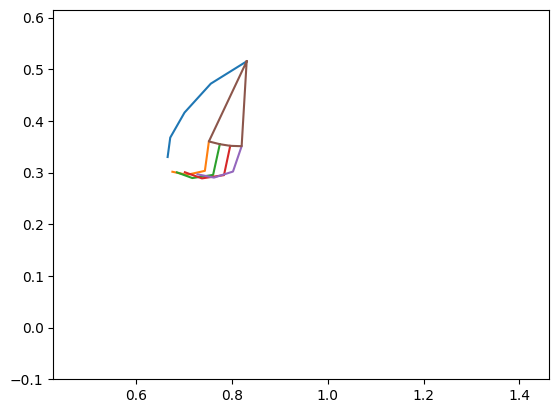

In [ ]:
#### VISUALIZE DATA

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

lips_m = np.nan_to_num(lips_3d[:,:,:,0:DIMS], copy=False)
lips_m[:,:,:,0] = lips_3d[:,:,:,0].max() - lips_3d[:,:,:,0]
left_m = np.nan_to_num(lefth_3d[:,:,:,0:DIMS], copy=False)
left_m[:,:,:,0] = lefth_3d[:,:,:,0].max() - lefth_3d[:,:,:,0]
pose_m = np.nan_to_num(pose_3d[:,:,:,0:DIMS], copy=False)
pose_m[:,:,:,0] = pose_3d[:,:,:,0].max() - pose_3d[:,:,:,0]
right_m = np.nan_to_num(righth_3d[:,:,:,0:DIMS], copy=False)
right_m[:,:,:,0] = righth_3d[:,:,:,0].max() - righth_3d[:,:,:,0]

#vid = left_m[20000,:,:,:]
vid = lefth_3d[20000,:,:,:]


# Functions to define landmark lines from the data
def get_hand_points(hand):
    x = [[hand[0,0],  hand[1,0],  hand[2,0],  hand[3,0], hand[4,0]], # Thumb
         [hand[5,0],  hand[6,0],  hand[7,0],  hand[8,0]], # Index
         [hand[9,0],  hand[10,0], hand[11,0], hand[12,0]], 
         [hand[13,0], hand[14,0], hand[15,0], hand[16,0]], 
         [hand[17,0], hand[18,0], hand[19,0], hand[20,0]], 
         [hand[0,0],  hand[5,0],  hand[9,0],  hand[13,0], hand[17,0], hand[0,0]]]

    y = [[hand[0,1],  hand[1,1],  hand[2,1],  hand[3,1], hand[4,1]], # Thumb
         [hand[5,1],  hand[6,1],  hand[7,1],  hand[8,1]], # Index
         [hand[9,1],  hand[10,1], hand[11,1], hand[12,1]], 
         [hand[13,1], hand[14,1], hand[15,1], hand[16,1]], 
         [hand[17,1], hand[18,1], hand[19,1], hand[20,1]], 
         [hand[0,1],  hand[5,1],  hand[9,1],  hand[13,1], hand[17,1], hand[0,1]]]

    return x, y

def animation_frame(v):
    lx, ly = get_hand_points(v)
    ax.clear()
    for i in range(len(lx)):
        ax.plot(lx[i], ly[i])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

xmin = vid[:,:,0].min() - 0.1
xmax = vid[:,:,0].max() + 0.1
ymin = vid[:,:,1].min() - 0.1
ymax = vid[:,:,1].max() + 0.1

fig, ax = plt.subplots()
(l,) = ax.plot([], [])
animation = FuncAnimation(fig, func=animation_frame, frames=vid, interval=300)

HTML(animation.to_html5_video())

## Training 

In [ ]:
class ASLData(Dataset):
    def __init__(self, datax, datay):
        self.datax = datax
        self.datay = datay

    def __getitem__(self, index):
        return self.datax[index, :], self.datay[index]

    def __len__(self):
        return len(self.datay)

# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
class ASLModel(nn.Module):
    def __init__(self, p):
        super(ASLModel, self).__init__()
        self.flatten = nn.Flatten()
        self.dropout0 = nn.Dropout(p)
        self.layer0 = nn.Linear(FRAMES_OUT * PTS_IN_FRAME * DIMS, 8192)
        self.layer1 = nn.Linear(8192, 2048)
        self.layer2 = nn.Linear(2048, 512)
        self.layer3 = nn.Linear(512, 250)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)
        self.batchnorm0 = nn.BatchNorm1d(FRAMES_OUT * PTS_IN_FRAME * DIMS)
        self.batchnorm1 = nn.BatchNorm1d(8192)
        self.batchnorm2 = nn.BatchNorm1d(2048)
        self.batchnorm3 = nn.BatchNorm1d(512)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.batchnorm0(x)
    
        x = self.layer0(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer1(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.layer3(x)

        return x

##### SAVE
# class ASLModel(nn.Module):
#     def __init__(self, p):
#         super(ASLModel, self).__init__()
#         self.flatten = nn.Flatten()
#         self.dropout0 = nn.Dropout(p)
#         self.layer0 = nn.Linear(FRAMES_OUT * PTS_IN_FRAME * DIMS, 8192)
#         self.dropout1 = nn.Dropout(p)
#         #self.layer0a = nn.Linear(8192, 2048)
#         self.layer1 = nn.Linear(8192, 512)
#         self.layer2 = nn.Linear(512, 250)
        
#     def forward(self, x):
#         x = self.flatten(x)
#         x = self.layer0(x)
#         x = self.dropout0(x)
#         #x = self.layer0a(x)
#         #x = self.dropout1(x)      
#         x = self.layer1(x)
#         x = self.layer2(x)
#         return x


In [ ]:
###############
# !!! TRAINING DOES NOT RUN ON MAC OS - (cuda)
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("++++using GPU++++")
else:
  device = torch.device("cpu")
  print("++++using CPU++++")

EPOCHS = 40
BATCH_SIZE = 64
start_time = time.perf_counter()
datax = torch.tensor(datax)  # Convert to Torch Tensor

trainx, testx, trainy, testy = train_test_split(datax, datay, test_size=0.15, random_state=42)

train_data = ASLData(trainx, trainy)
valid_data = ASLData(testx, testy)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE, num_workers=4, shuffle=False)

model = ASLModel(0.2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
sched = torch.optim.lr_scheduler.StepLR(opt, step_size=300, gamma=0.95)

for i in range(EPOCHS):
    model.train()
    
    train_loss_sum = 0.
    train_correct = 0
    train_total = 0
    train_bar = train_loader
    for x,y in train_bar:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)  
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        train_loss_sum += loss.item()
        train_correct += np.sum((np.argmax(y_pred.detach().cpu().numpy(), axis=1) == y.cpu().numpy()))
        train_total += 1
        sched.step()
        
    val_loss_sum = 0.
    val_correct = 0
    val_total = 0
    model.eval()
    for x,y in val_loader:
        x = torch.Tensor(x).float().to(device)
        y = torch.Tensor(y).long().to(device)
        
        with torch.no_grad():
            y_pred = model(x)
            loss = criterion(y_pred, y)
            val_loss_sum += loss.item()
            val_correct += np.sum((np.argmax(y_pred.cpu().numpy(), axis=1) == y.cpu().numpy()))
            val_total += 1
    print(f"DIM={DIMS} FRAMES={FRAMES_OUT}, FEAT={PTS_IN_FRAME}")                          
    print(f"Epoch:{i} > Train Loss: {(train_loss_sum/train_total):.04f}, Train Acc: {train_correct/len(train_data):0.04f}")
    print(f"Epoch:{i} > Val Loss: {(val_loss_sum/val_total):.04f}, Val Acc: {val_correct/len(valid_data):0.04f}")
    print("="*50)

# Save the pytorch model
py_model_path = f"{WORKING_DIR}/py_model.pt"
torch.save(model, py_model_path)

print("#### ELAPSED TIME:", time.perf_counter()-start_time)



++++using GPU++++
DIM=3 FRAMES=8, FEAT=115
Epoch:0 > Train Loss: 4.5570, Train Acc: 0.0778
Epoch:0 > Val Loss: 3.5302, Val Acc: 0.1950
DIM=3 FRAMES=8, FEAT=115
Epoch:1 > Train Loss: 3.2989, Train Acc: 0.2371
Epoch:1 > Val Loss: 2.8187, Val Acc: 0.3314
DIM=3 FRAMES=8, FEAT=115
Epoch:2 > Train Loss: 2.8217, Train Acc: 0.3275
Epoch:2 > Val Loss: 2.5146, Val Acc: 0.3975
DIM=3 FRAMES=8, FEAT=115
Epoch:3 > Train Loss: 2.5204, Train Acc: 0.3884
Epoch:3 > Val Loss: 2.2860, Val Acc: 0.4503
DIM=3 FRAMES=8, FEAT=115
Epoch:4 > Train Loss: 2.2909, Train Acc: 0.4361
Epoch:4 > Val Loss: 2.1482, Val Acc: 0.4795
DIM=3 FRAMES=8, FEAT=115
Epoch:5 > Train Loss: 2.0963, Train Acc: 0.4783
Epoch:5 > Val Loss: 2.0445, Val Acc: 0.5095
DIM=3 FRAMES=8, FEAT=115
Epoch:6 > Train Loss: 1.9475, Train Acc: 0.5115
Epoch:6 > Val Loss: 1.9489, Val Acc: 0.5322
DIM=3 FRAMES=8, FEAT=115
Epoch:7 > Train Loss: 1.8074, Train Acc: 0.5416
Epoch:7 > Val Loss: 1.9025, Val Acc: 0.5438
DIM=3 FRAMES=8, FEAT=115
Epoch:8 > Train Loss:

KeyboardInterrupt: ignored

In [ ]:
# SAVE MODEL
py_model_path = f"/content/drive/MyDrive/GaggleSignLang/py_model_a.pt"
torch.save(model, py_model_path)

# Results Log

In [ ]:
==================================================
(New relu MODEL with normaization in model before lin-0)
DIM=3 FRAMES=8, FEAT=115
Epoch:26 > Train Loss: 1.0967, Train Acc: 0.7038
Epoch:26 > Val Loss: 1.8132, Val Acc: 0.5862
==================================================

==================================================
(New relu MODEL with normaization in model before lin-0)
DIM=3 FRAMES=24, FEAT=115
Epoch:19 > Train Loss: 1.0077, Train Acc: 0.7236
Epoch:19 > Val Loss: 2.0781, Val Acc: 0.5627
==================================================

==================================================
(New relu MODEL with normaization in model before lin-0)
DIM=3 FRAMES=12, FEAT=115
Epoch:22 > Train Loss: 1.0752, Train Acc: 0.7082
Epoch:22 > Val Loss: 1.8655, Val Acc: 0.5789
==================================================

==================================================
(New relu MODEL with normaization in model before lin-0)
DIM=3 FRAMES=16, FEAT=115 principle hand (
Epoch:22 > Train Loss: 1.0258, Train Acc: 0.7206
Epoch:22 > Val Loss: 1.8558, Val Acc: 0.5756
==================================================

so far, 3-layers better than 4, 12-Frams better than 16
Mirror primary hand better

==================================================
DIM=3 FRAMES=16, FEAT=115 principle hand (3-LAYER MODEL)
Epoch:39 > Train Loss: 2.1561, Train Acc: 0.5348
Epoch:39 > Val Loss: 2.6863, Val Acc: 0.4374
==================================================


==================================================
DIM=3 FRAMES=12, FEAT=115 principle hand (3-LAYER MODEL)
Epoch:39 > Train Loss: 2.1814, Train Acc: 0.5276
Epoch:39 > Val Loss: 2.6334, Val Acc: 0.4419
==================================================

==================================================
DIM=3 FRAMES=12, FEAT=115 principle hand (4-LAYER MODEL)
Epoch:39 > Train Loss: 2.3148, Train Acc: 0.5017
Epoch:39 > Val Loss: 2.7143, Val Acc: 0.4246
==================================================

12 Frames 3d, 4xlinear
==================================================
Epoch:34 > Train Loss: 2.5521, Train Acc: 0.4556
Epoch:34 > Val Loss: 2.7123, Val Acc: 0.4221
==================================================



32 FRAMES_OUT 3xlinear
==================================================
Epoch:39 > Train Loss: 2.2568, Train Acc: 0.5093
Epoch:39 > Val Loss: 2.8198, Val Acc: 0.4007
==================================================

16 FRAMES_OUT 3xlinear
==================================================
Epoch:39 > Train Loss: 2.2368, Train Acc: 0.5112
Epoch:39 > Val Loss: 2.6392, Val Acc: 0.4321
==================================================

12 FRAMES_OUT 3xlinear
==================================================
Epoch:39 > Train Loss: 2.3254, Train Acc: 0.4921
Epoch:39 > Val Loss: 2.6272, Val Acc: 0.4351
==================================================

8 FRAMES_OUT 3xlinear
==================================================
Epoch:39 > Train Loss: 2.4085, Train Acc: 0.4752
Epoch:39 > Val Loss: 2.6766, Val Acc: 0.4238
==================================================

In [ ]:
## LOAD SAVED MODLE
py_model_path = f"/content/drive/MyDrive/GaggleSignLang/py_model_a.pt"
model = torch.load(py_model_path)

ACCURACY 0.5779706463449055
   truth  pred
0  206.0   247
1   20.0    96
2  178.0   200
3  114.0   114
4  221.0   221
   truth  pred    acc
0  206.0   247  False
1   20.0    96  False
2  178.0   200  False
3  114.0   114   True
4  221.0   221   True
            acc
truth          
1.0    0.148148
97.0   0.183333
11.0   0.246377
95.0   0.288889
74.0   0.294118


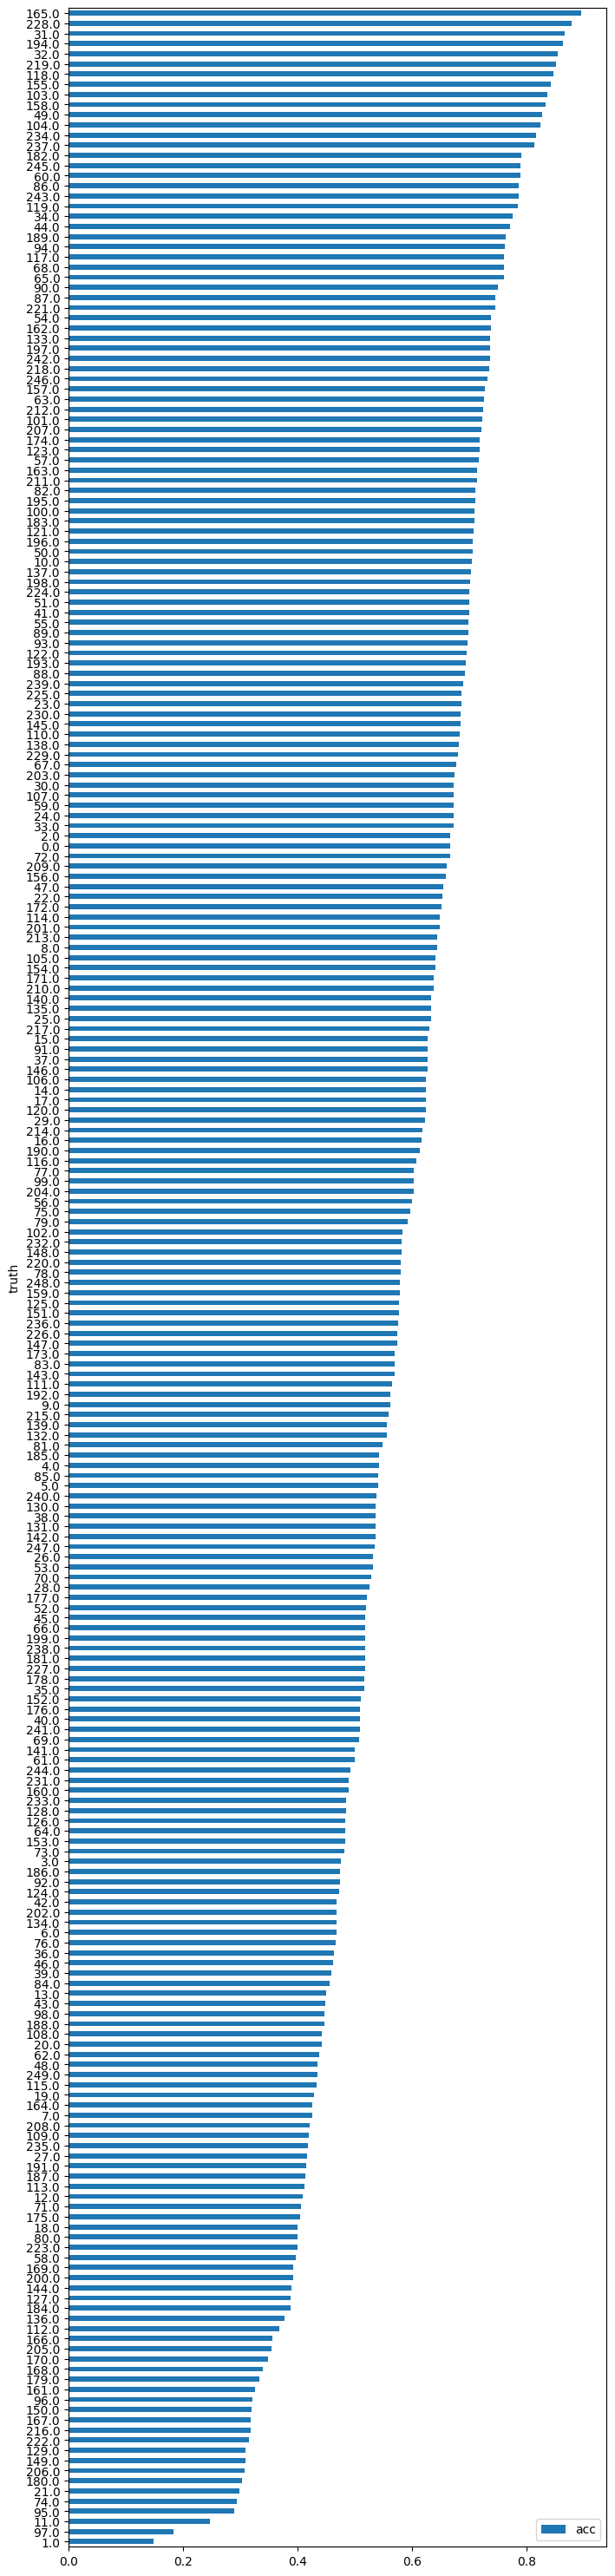

pred <class 'torch.Tensor'> torch.Size([14172, 250]) 14172
tensor([[-14.0270,  -6.8275, -10.4026,  ...,   3.4487, -17.6600, -15.4969],
        [-11.5640,  -0.6240, -19.4280,  ..., -18.2741, -15.6071, -19.0983],
        [-19.8037, -10.4941, -16.8725,  ..., -10.6831,  -9.3887, -10.1814],
        ...,
        [-10.9205,  -7.3123, -16.3157,  ...,  -8.7244, -13.4961,  -7.0872],
        [-14.9619,  -6.0237,  -8.0871,  ...,  -4.1137,   0.2946,  -3.4269],
        [ -5.3026,  -4.0632, -12.0489,  ...,  -6.8534,  -7.6811, -10.9893]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
datay <class 'numpy.ndarray'> 94477


In [ ]:
import matplotlib.pyplot as plt
model.eval()
pred = model(torch.Tensor(testx).float().to(device))
_, p2 = torch.max(pred, dim = 1)

p2 = p2.detach().cpu().numpy()

print("ACCURACY", np.mean(p2 == testy))

df_y = pd.DataFrame(data={'truth':testy, 'pred':p2})
print(df_y.head())
df_y["acc"] = df_y['truth'] == df_y['pred']
print(df_y.head())
df_sum = df_y[['truth', 'acc']].groupby('truth').mean('acc').sort_values(by=['acc'])
print(df_sum.head())
fig, ax = plt.subplots(figsize=(8, 38))
df_sum.sort_values(by=['acc']).iloc[0:251].plot(kind="barh", ax=ax)
#ax.set_title("Number Frames per Video by Participant", fontsize=18)
#ax.set_xlabel("Frames/Video", fontsize=16)
#ax.set_ylabel("Paricipant", fontsize=16)
plt.show()

print("pred", type(pred), pred.shape, len(pred))
print(pred)
print("datay", type(datay), len(datay))


#label_map = json.load(open(f"{WORKING_DIR}/sign_to_prediction_index_map.json", "r"))
#print("label map", type(label_map), len(label_map))
#df['label'] = df['sign'].map(label_map)
#d = {'truth':datay, 'pred':y_pred}
#results = pd.dataframe(d)
#print(results)